In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import numpy as np

import torch
from torch.utils.data import Subset

In [3]:
from lib.dataset import unpack_drawings
from lib.dataset import get_n_points, cut_strokes
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import strokes_to_points, points_to_strokes
from lib.dataset import END_OF_STROKE_VALUE, PADDING_VALUE
from lib.plot import get_canvas, plot, get_animation
from lib.model import LSTM, evaluate, generate, masked_mse_loss, train

# Load and show dataset

In [4]:
dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = list(dataset)

In [5]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

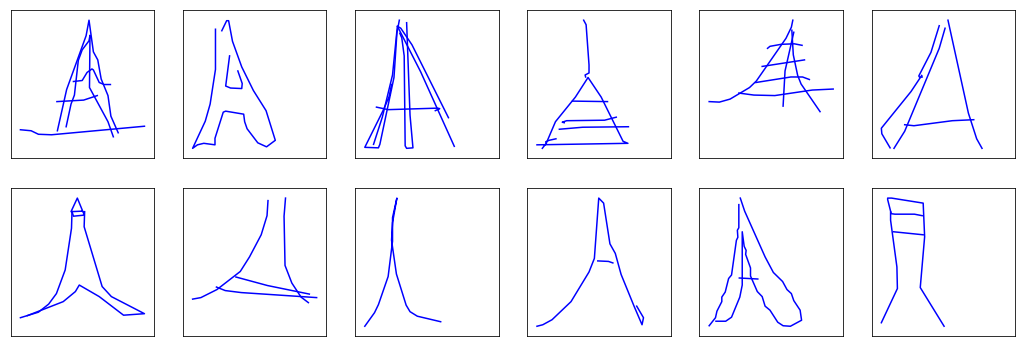

In [6]:
fig, axarr = get_canvas(2, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

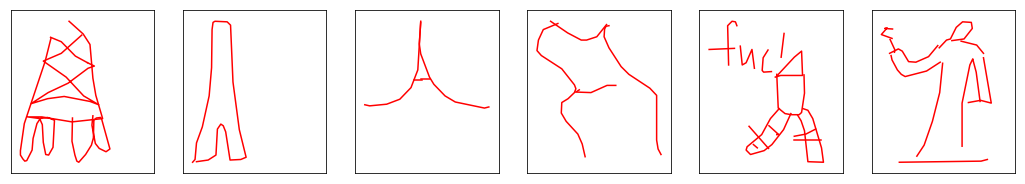

In [7]:
fig, axarr = get_canvas(1, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [8]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [9]:
HTML(anim.to_html5_video())

In [10]:
anim.save('effeil.gif', dpi=80, writer='imagemagick')

# Create pytorch dataset

In [11]:
drawings = [drawing for drawing in good_drawings if 10 <= get_n_points(drawing) <= 50]
ds = get_dataset(drawings)

In [12]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=1)

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(92536, 30916)

In [13]:
# Debug
train_batches = get_batches(train_ds, batch_size=3)
data_batch, labels_batch, lens_batch = next(iter(train_batches))
data_batch.shape, labels_batch.shape, lens_batch.shape

(torch.Size([72, 3, 2]), torch.Size([72, 3, 2]), torch.Size([3]))

# Train

In [23]:
batch_size = 2048
n_hidden = 256
n_layers = 1
dropout = 0.3 if n_layers > 1 else 0

lstm = LSTM(batch_size, n_hidden, n_layers, dropout)
if torch.cuda.is_available():
    lstm = lstm.cuda()

criterion = masked_mse_loss
optimizer = torch.optim.Adam(lstm.parameters(), 1e-2)

In [16]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=100, epochs_between_evals=20)

epoch:   1   train_loss: 6041.28   val_loss: 5970.20
epoch:  20   train_loss: 6159.49   val_loss: 6072.64
epoch:  40   train_loss: 5933.78   val_loss: 5859.21
epoch:  60   train_loss: 6013.06   val_loss: 5926.66
epoch:  80   train_loss: 5928.31   val_loss: 5849.36
epoch: 100   train_loss: 6054.82   val_loss: 5961.78


In [17]:
#torch.save(lstm.state_dict(), 'model1.pth')

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3

In [18]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=200, epochs_between_evals=20)

epoch:   1   train_loss: 5820.51   val_loss: 5747.98
epoch:  20   train_loss: 5803.19   val_loss: 5723.25
epoch:  40   train_loss: 5806.27   val_loss: 5719.54
epoch:  60   train_loss: 5763.88   val_loss: 5668.04
epoch:  80   train_loss: 5722.28   val_loss: 5624.65
epoch: 100   train_loss: 5732.77   val_loss: 5640.68
epoch: 120   train_loss: 5702.33   val_loss: 5602.63
epoch: 140   train_loss: 5689.29   val_loss: 5589.93
epoch: 160   train_loss: 5700.74   val_loss: 5597.19
epoch: 180   train_loss: 5696.27   val_loss: 5576.07
epoch: 200   train_loss: 5682.33   val_loss: 5570.79


In [ ]:
#torch.save(lstm.state_dict(), 'model2.pth')

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4

In [ ]:
train(lstm, optimizer, criterion, train_ds, val_ds, batch_size, epochs=300, epochs_between_evals=20)

epoch:   1   train_loss: 5622.72   val_loss: 5532.17
epoch:  20   train_loss: 5587.02   val_loss: 5488.33
epoch:  40   train_loss: 5574.94   val_loss: 5495.65
epoch:  60   train_loss: 5573.42   val_loss: 5505.19
epoch:  80   train_loss: 5574.92   val_loss: 5503.51
epoch: 100   train_loss: 5562.88   val_loss: 5496.43
epoch: 120   train_loss: 5560.09   val_loss: 5499.32
epoch: 140   train_loss: 5551.01   val_loss: 5490.18
epoch: 160   train_loss: 5568.30   val_loss: 5486.13
epoch: 180   train_loss: 5556.72   val_loss: 5477.24
epoch: 200   train_loss: 5549.41   val_loss: 5471.23
epoch: 220   train_loss: 5551.95   val_loss: 5475.55
epoch: 240   train_loss: 5554.56   val_loss: 5481.35
epoch: 260   train_loss: 5554.99   val_loss: 5480.68
epoch: 280   train_loss: 5550.73   val_loss: 5478.91
epoch: 300   train_loss: 5542.18   val_loss: 5470.97


In [ ]:
#torch.save(lstm.state_dict(), 'model3.pth')

# Predict

In [24]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
lstm.load_state_dict(torch.load('model3.pth', map_location=map_location))

In [58]:
n_initial_points = 5

idx = np.random.choice(len(val_ds))
points = val_ds[idx][0]
initial_points = points[:n_initial_points]

In [59]:
pred_points = generate(lstm, initial_points, 10)

In [60]:
%%capture

from lib.plot import get_animation

strokes = points_to_strokes(points)
anim = get_animation(strokes)

cut_drawing = cut_strokes(strokes, len(initial_points))
cut_anim = get_animation(cut_drawing)

pred_strokes = points_to_strokes(pred_points)
pred_anim = get_animation(pred_strokes)

In [61]:
# Initial points for drawing
HTML(cut_anim.to_html5_video())

In [62]:
# Ground truth drawing
HTML(anim.to_html5_video())

In [63]:
# Generated drawing
HTML(pred_anim.to_html5_video())